 Importing Libraries and Setting Up

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
import scipy.sparse as sp
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
import nltk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

nltk.download('punkt')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

2. Loading and Splitting the Data

In [3]:
data = pd.read_csv('/content/cleaned_masterDataset.csv')
X = data['Body']
y = data['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


 Word2Vec Vectorization

In [4]:
def tokenize_text(text):
    return word_tokenize(text)

X_train_tokenized = X_train.apply(tokenize_text)
X_val_tokenized = X_val.apply(tokenize_text)
X_test_tokenized = X_test.apply(tokenize_text)

# Train Word2Vec model
word2vec_model = Word2Vec(X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        length = len(vectorized)
        summed = np.sum(vectorized, axis=0)
        averaged = np.divide(summed, length)
        return averaged

X_train_word2vec = np.array([get_average_word2vec(s, word2vec_model.wv) for s in X_train_tokenized])
X_val_word2vec = np.array([get_average_word2vec(s, word2vec_model.wv) for s in X_val_tokenized])
X_test_word2vec = np.array([get_average_word2vec(s, word2vec_model.wv) for s in X_test_tokenized])


4. Computing and Combining Features

In [5]:
def compute_text_length(text):
    if isinstance(text, str):
        return len(text)
    else:
        return 0

X_train_length = np.array(X_train.apply(compute_text_length))
X_val_length = np.array(X_val.apply(compute_text_length))
X_test_length = np.array(X_test.apply(compute_text_length))

X_train_combined = np.hstack((X_train_word2vec, X_train_length[:, None]))
X_val_combined = np.hstack((X_val_word2vec, X_val_length[:, None]))
X_test_combined = np.hstack((X_test_word2vec, X_test_length[:, None]))


5. Training a Random Forest Classifier

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_combined, y_train)


RandomForestClassifier(random_state=42)

6. Model Evaluation

In [7]:
y_test_pred = rf_classifier.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Test Accuracy: 0.9204

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1711
           1       0.92      0.84      0.88       877

    accuracy                           0.92      2588
   macro avg       0.92      0.90      0.91      2588
weighted avg       0.92      0.92      0.92      2588


Confusion Matrix:
[[1648   63]
 [ 143  734]]


7. Confusion Matrix Visualization

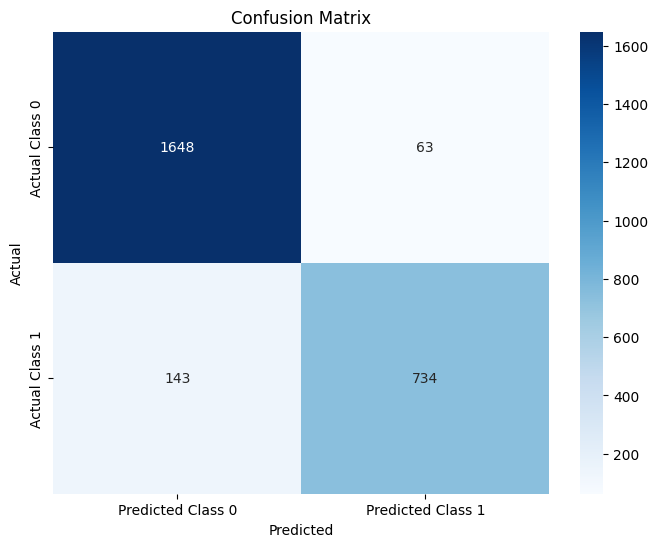

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


8. Adding Misspelled Words Feature


In [9]:
spell = SpellChecker()

def count_misspelled_words(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        misspelled = spell.unknown(tokens)
        return len(misspelled)
    else:
        return 0

X_train_misspelled = np.array(X_train.apply(count_misspelled_words))
X_val_misspelled = np.array(X_val.apply(count_misspelled_words))
X_test_misspelled = np.array(X_test.apply(count_misspelled_words))

X_train_combined = np.hstack((X_train_word2vec, X_train_misspelled[:, None], X_train_length[:, None]))
X_val_combined = np.hstack((X_val_word2vec, X_val_misspelled[:, None], X_val_length[:, None]))
X_test_combined = np.hstack((X_test_word2vec, X_test_misspelled[:, None], X_test_length[:, None]))


9. Retraining the Random Forest Classifier


In [10]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_combined, y_train)


RandomForestClassifier(random_state=42)

10. Reevaluating the Model


In [11]:
y_test_pred = rf_classifier.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Test Accuracy: 0.9185

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1711
           1       0.91      0.84      0.87       877

    accuracy                           0.92      2588
   macro avg       0.92      0.90      0.91      2588
weighted avg       0.92      0.92      0.92      2588


Confusion Matrix:
[[1642   69]
 [ 142  735]]


11. Confusion Matrix Visualization (Repeated)


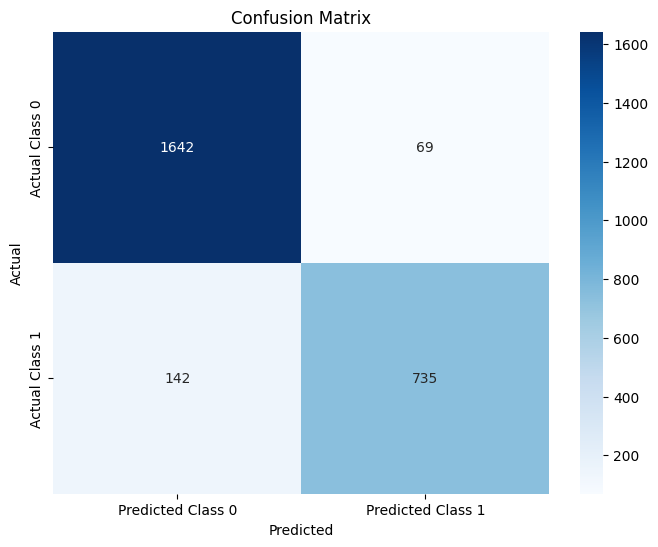

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


12. Hyperparameter Tuning


In [13]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}

rf_classifier = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train_combined, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Score: {best_score:.4f}')


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 63}
Best Cross-Validation Score: 0.9184


13. Training with Best Parameters


In [14]:
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train_combined, y_train)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=3, n_estimators=63,
                       random_state=42)

14. Final Model Evaluation


Validation Accuracy: 0.9169
Test Accuracy: 0.9189

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1711
           1       0.91      0.84      0.88       877

    accuracy                           0.92      2588
   macro avg       0.92      0.90      0.91      2588
weighted avg       0.92      0.92      0.92      2588


Confusion Matrix:
[[1642   69]
 [ 141  736]]


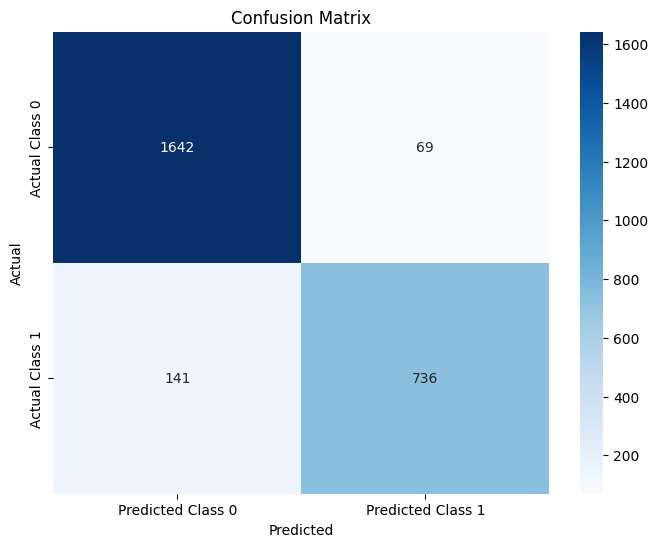

In [15]:
y_val_pred = best_rf_classifier.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

y_test_pred = best_rf_classifier.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

class_report = classification_report(y_test, y_test_pred)
print("\nClassification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


15. ROC Curve and AUC Score

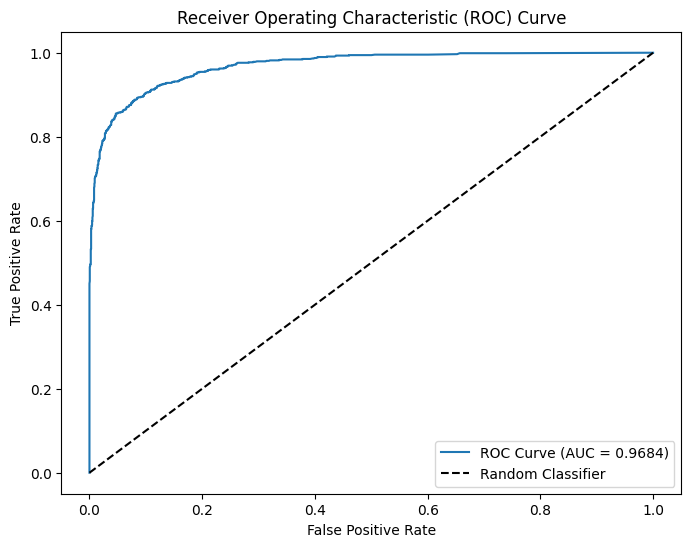

AUC Score: 0.9684


In [16]:
y_test_prob = best_rf_classifier.predict_proba(X_test_combined)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc_score = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f'AUC Score: {auc_score:.4f}')
